In [1]:
# Import libraries to be used
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy
import time
import gym

# Set random seed 
import random
random.seed(27)

# Only warn once
import warnings
warnings.filterwarnings('ignore')

# Plot inline
%matplotlib inline

In [2]:
import sys
from contextlib import closing

import numpy as np
from six import StringIO, b

from gym import utils
from gym.envs.toy_text import discrete

LEFT = 0
DOWN = 1
RIGHT = 2
UP = 3

MAPS = {
    "4x4": [
        "SFFF",
        "FHFH",
        "FFFH",
        "HFFG"
    ],
    "8x8": [
        "SFFFFFFF",
        "FFHHHFFF",
        "FFFHFFFF",
        "FFFFFHFF",
        "FFHHFFFF",
        "FHHFFFHF",
        "FHFFHFHF",
        "FFFHFFFG"
    ],
    "15x15": [
        "SFFFFFFHHFFFFFF",
        "FFFFFFFFFFFHHFF",
        "FFFHFFHHFFFFFFF",
        "FFFFFHFFFFFHHFF",
        "FFFFFHFFFFFHHFF",
        "FFFFFHFFFFFHHFF",
        "FFFFFFFFFFFHHFF",
        "FFFFFHFFFFFHHFF",
        "FFFFFFFFFFFHHFF",
        "FFFFFFFFFFFHHFF",
        "FFFFFFFHHHFHHFF",
        "HHHHFFFFFFFHHFF",
        "FFFFFHHHFFFHHFF",
        "FHHFFFHFFFFFFFF",
        "FFFHFFFFFHHFHFG"
    ],
    "20x20": [
        "SFFFFFFHHHFFFFFFFFFF",
        "FFFFFFFFFFFFFFFFHHFF",
        "FFFHFFFFFFFHHFFFFFFF",
        "FFFFFHFFFFFFFFFFHHFF",
        "FFFFFHFFFFFFFFFFHHFF",
        "FFFFFHFFFFFFFFFFHHFF",
        "FFFFFFFFHFFFFFFFHHFF",
        "FFFFFHFFFFHHFFFFHHFF",
        "FFFFFHFFFFFFFFFFHHFF",
        "FFFFFHFFFFFFFFFFHHFF",
        "FFFFFFFFFFFHHHHHHHFF",
        "HHHHFHFFFFFFFFFFHHFF",
        "FFFFFHFFFFHHHFFFHHFF",
        "FFFFFFFFFFFFFFFFHHFF",
        "FFFFFHFFFFFFHFFFHHFF",
        "FFFFFHFFFFFFFFFFHHFF",
        "FFFFFFFFFFFHFFFFFFFF",
        "FHHFFFHFFFFHFFFFFHFF",
        "FHHFHFHFFFFFFFFFFFFF",
        "FFFHFFFFFHFFFFHHFHFG"
    ]
}


def generate_random_map(size=8, p=0.8):
    """Generates a random valid map (one that has a path from start to goal)
    :param size: size of each side of the grid
    :param p: probability that a tile is frozen
    """
    valid = False

    # DFS to check that it's a valid path.
    def is_valid(res):
        frontier, discovered = [], set()
        frontier.append((0,0))
        while frontier:
            r, c = frontier.pop()
            if not (r,c) in discovered:
                discovered.add((r,c))
                directions = [(1, 0), (0, 1), (-1, 0), (0, -1)]
                for x, y in directions:
                    r_new = r + x
                    c_new = c + y
                    if r_new < 0 or r_new >= size or c_new < 0 or c_new >= size:
                        continue
                    if res[r_new][c_new] == 'G':
                        return True
                    if (res[r_new][c_new] not in '#H'):
                        frontier.append((r_new, c_new))
        return False

    while not valid:
        p = min(1, p)
        res = np.random.choice(['F', 'H'], (size, size), p=[p, 1-p])
        res[0][0] = 'S'
        res[-1][-1] = 'G'
        valid = is_valid(res)
    return ["".join(x) for x in res]


class FrozenLakeEnv(discrete.DiscreteEnv):
    """
    Winter is here. You and your friends were tossing around a frisbee at the park
    when you made a wild throw that left the frisbee out in the middle of the lake.
    The water is mostly frozen, but there are a few holes where the ice has melted.
    If you step into one of those holes, you'll fall into the freezing water.
    At this time, there's an international frisbee shortage, so it's absolutely imperative that
    you navigate across the lake and retrieve the disc.
    However, the ice is slippery, so you won't always move in the direction you intend.
    The surface is described using a grid like the following
        SFFF
        FHFH
        FFFH
        HFFG
    S : starting point, safe
    F : frozen surface, safe
    H : hole, fall to your doom
    G : goal, where the frisbee is located
    The episode ends when you reach the goal or fall in a hole.
    You receive a reward of 1 if you reach the goal, and zero otherwise.
    """

    metadata = {'render.modes': ['human', 'ansi']}

    def __init__(self, desc=None, map_name="4x4",is_slippery=True, custom_map = None):
        if custom_map is not None:
            desc = generate_random_map(size=custom_map, p=0.8)
        elif desc is None and map_name is None:
            desc = generate_random_map(size=n, p=0.8)
        elif desc is None:
            desc = MAPS[map_name]
        self.desc = desc = np.asarray(desc,dtype='c')
        self.nrow, self.ncol = nrow, ncol = desc.shape
        self.reward_range = (0, 1)

        nA = 4
        nS = nrow * ncol

        isd = np.array(desc == b'S').astype('float64').ravel()
        isd /= isd.sum()

        P = {s : {a : [] for a in range(nA)} for s in range(nS)}

        def to_s(row, col):
            return row*ncol + col

        def inc(row, col, a):
            if a == LEFT:
                col = max(col-1,0)
            elif a == DOWN:
                row = min(row+1,nrow-1)
            elif a == RIGHT:
                col = min(col+1,ncol-1)
            elif a == UP:
                row = max(row-1,0)
            return (row, col)

        for row in range(nrow):
            for col in range(ncol):
                s = to_s(row, col)
                for a in range(4):
                    li = P[s][a]
                    letter = desc[row, col]
                    if letter in b'GH':
                        li.append((1.0, s, 0, True))
                    else:
                        if is_slippery:
                            for b in [(a-1)%4, a, (a+1)%4]:
                                newrow, newcol = inc(row, col, b)
                                newstate = to_s(newrow, newcol)
                                newletter = desc[newrow, newcol]
                                done = bytes(newletter) in b'GH'
                                rew = float(newletter == b'G')
                                li.append((1.0/3.0, newstate, rew, done))
                        else:
                            newrow, newcol = inc(row, col, a)
                            newstate = to_s(newrow, newcol)
                            newletter = desc[newrow, newcol]
                            done = bytes(newletter) in b'GH'
                            rew = float(newletter == b'G')
                            li.append((1.0, newstate, rew, done))

        super(FrozenLakeEnv, self).__init__(nS, nA, P, isd)

    def render(self, mode='human'):
        outfile = StringIO() if mode == 'ansi' else sys.stdout

        row, col = self.s // self.ncol, self.s % self.ncol
        desc = self.desc.tolist()
        desc = [[c.decode('utf-8') for c in line] for line in desc]
        desc[row][col] = utils.colorize(desc[row][col], "red", highlight=True)
        if self.lastaction is not None:
            outfile.write("  ({})\n".format(["Left","Down","Right","Up"][self.lastaction]))
        else:
            outfile.write("\n")
        outfile.write("\n".join(''.join(line) for line in desc)+"\n")

        if mode != 'human':
            with closing(outfile):
                return outfile.getvalue()


In [109]:
env = FrozenLakeEnv(map_name = None, custom_map = 15)
env.render()
env.reset()
done = False
i = 0
while done == False:
    action = env.action_space.sample()
    new_state, reward, done, info = env.step(action)
    if done == True:
        print(reward)
        print(i)
        break
    i += 1


SFFHFFFFFFFFHFF
FFHFFFFFFFFFFFF
FFFFHFHFFFFFFFF
FHHFFHHFFFFFHFF
HFFHFFFFFFFFFHH
HFFFFHFHHFHFFHH
FFFFFFFFHFFFFFF
FFFFFFFFHFFFFFH
FFFFFFFFFFFFHFF
FFFFFFFFFFFHHFF
FHFFFHFHHFHFFFF
FHFHFFFFFFHFFFF
HFHFHFFHFFHFHHF
FFFFFFHFHFFFFFH
HFFHFHFFFHFFHFG
0.0
8


In [51]:
# Value iteration adopted from https://medium.com/@m.alzantot/deep-reinforcement-learning-demysitifed-episode-2-policy-iteration-value-iteration-and-q-978f9e89ddaa

import numpy as np
import gym
from gym import wrappers


def run_episode(env, policy, gamma = 1.0, render = False):
    """ Evaluates policy by using it to run an episode and finding its
    total reward.
    args:
    env: gym environment.
    policy: the policy to be used.
    gamma: discount factor.
    render: boolean to turn rendering on/off.
    returns:
    total reward: real value of the total reward recieved by agent under policy.
    """
    obs = env.reset()
    total_reward = 0
    step_idx = 0
    while True:
        if render:
            env.render()
        obs, reward, done , _ = env.step(int(policy[obs]))
        total_reward += (gamma ** step_idx * reward)
        step_idx += 1
        if done:
            break
    return total_reward, step_idx


def evaluate_policy(env, policy, gamma = 1.0,  n = 10):
    """ Evaluates a policy by running it n times.
    returns:
    average total reward
    """
    ev_scores = []
    ev_steps = []
    for i in range(n):
        scores, steps = run_episode(env, policy, gamma = gamma, render = False)
        ev_scores.append(scores)
        ev_steps.append(steps)
    #scores, steps = [
    #        run_episode(env, policy, gamma = gamma, render = False)
    #        for _ in range(n)]
    return np.mean(ev_scores), np.mean(ev_steps)

def extract_policy(v, gamma = 1.0):
    """ Extract the policy given a value-function """
    policy = np.zeros(env.nS)
    for s in range(env.nS):
        q_sa = np.zeros(env.action_space.n)
        for a in range(env.action_space.n):
            for next_sr in env.P[s][a]:
                # next_sr is a tuple of (probability, next state, reward, done)
                p, s_, r, _ = next_sr
                q_sa[a] += (p * (r + gamma * v[s_]))
        policy[s] = np.argmax(q_sa)
    return policy


def value_iteration(env, gamma = 1.0, training_iters = 5000):
    if training_iters > 0 and training_iters <= 5000:
        max_iterations = 5000
    else:
        max_iterations = 30000
    """ Value-iteration algorithm """
    score = []
    cum_score = []
    steps = []
    runtime = []
    iteration_converged = 0
    v = np.zeros(env.nS)  # initialize value-function
    #max_iterations = 20000
    total_score = 0
    eps = 1e-20
    for i in range(max_iterations):
        #print(i)
        t0 = time.time()
        prev_v = np.copy(v)
        for s in range(env.nS):
            q_sa = [sum([p*(r + prev_v[s_]) for p, s_, r, _ in env.P[s][a]]) for a in range(env.nA)] 
            v[s] = max(q_sa)
            
        policy = extract_policy(v, gamma)
        iteration_score, steps_idx = evaluate_policy(env, policy, gamma, n=10)
        total_score += iteration_score
        score.append(iteration_score) 
        cum_score.append(total_score)
        steps.append(steps_idx)
        
        if (np.sum(np.fabs(prev_v - v)) <= eps) or (i == training_iters):
            print ('Value-iteration converged at iteration# %d.' %(i))
            iteration_converged = i
            t1 = time.time()
            run = t1-t0
            runtime.append(run)
            break
        
        t1 = time.time()
        run = t1-t0
        runtime.append(run)
            
    iterations_remaining = max_iterations - i
    
    for rem in range(iterations_remaining):
        #policy = extract_policy(v, gamma)
        t0 = time.time()
        iteration_score, steps_idx = evaluate_policy(env, policy, gamma, n=10)
        total_score += iteration_score
        score.append(iteration_score)
        cum_score.append(total_score)
        steps.append(steps_idx)
        t1 = time.time()
        run = t1-t0
        runtime.append(run)
            
    return v, score, cum_score, iteration_converged, steps, runtime

In [52]:
%%time
env = FrozenLakeEnv(map_name = None, custom_map = 8)
gamma = 1.0
#env.render()
optimal_v_100, score_100, cum_score_100, iteration_converged_100, steps_100, run100svi = value_iteration(env, gamma, training_iters = 100);
optimal_v_1000, score_1000, cum_score_1000, iteration_converged_1000, steps_1000, run1000svi = value_iteration(env, gamma, training_iters = 1000);
optimal_v_5000, score_5000, cum_score_5000, iteration_converged_5000, steps_5000, run5000svi = value_iteration(env, gamma, training_iters = 5000);

Value-iteration converged at iteration# 100.
Value-iteration converged at iteration# 1000.
Value-iteration converged at iteration# 2999.
Wall time: 2min 30s


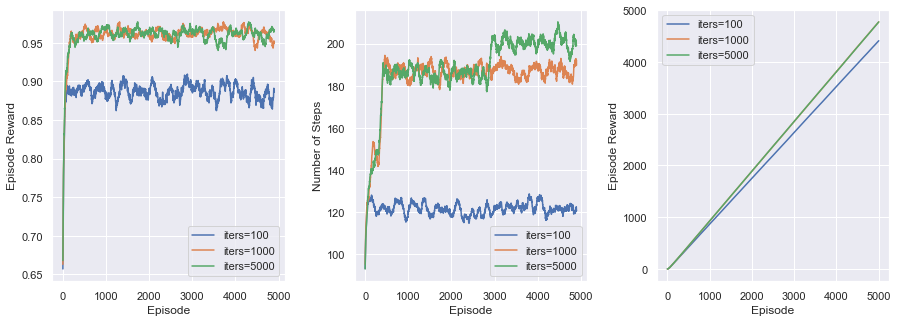

In [54]:
# Moving average function adopted from https://stackoverflow.com/questions/14313510/how-to-calculate-moving-average-using-numpy
def moving_average(x, n):
    return np.convolve(x, np.ones(n), 'valid') / n

ma_score_100 = moving_average(score_100, n=100)
ma_score_1000 = moving_average(score_1000, n=100)
ma_score_5000 = moving_average(score_5000, n=100)
ma_steps_100 = moving_average(steps_100, n=100)
ma_steps_1000 = moving_average(steps_1000, n=100)
ma_steps_5000 = moving_average(steps_5000, n=100)

fig = plt.figure(figsize=(15,5))
sns.set(color_codes=True)
plt.subplots_adjust(wspace=0.3)
plt.subplot(1,3,1)
plt.plot(ma_score_100, label = 'iters=100')
#plt.axvline(x=iteration_converged_100, color = 'blue')
plt.plot(ma_score_1000, label = 'iters=1000')
#plt.axvline(x=iteration_converged_1000, color = 'orange')
plt.plot(ma_score_5000, label = 'iters=5000')
#plt.axvline(x=iteration_converged_5000, color = 'green')
plt.xlabel('Episode')
plt.ylabel('Episode Reward')
plt.grid(True)
plt.legend()
plt.subplot(1,3,3)
plt.plot(cum_score_100, label = 'iters=100')
#plt.axvline(x=iteration_converged_100, color = 'blue')
plt.plot(cum_score_1000, label = 'iters=1000')
#plt.axvline(x=iteration_converged_1000, color = 'orange')
plt.plot(cum_score_5000, label = 'iters=5000')
#plt.axvline(x=iteration_converged_5000, color = 'green')
plt.xlabel('Episode')
plt.ylabel('Episode Reward')
plt.grid(True)
plt.legend()
plt.subplot(1,3,2)
plt.plot(ma_steps_100, label = 'iters=100')
#plt.axvline(x=iteration_converged_100, color = 'blue')
plt.plot(ma_steps_1000, label = 'iters=1000')
#plt.axvline(x=iteration_converged_1000, color = 'orange')
plt.plot(ma_steps_5000, label = 'iters=5000')
#plt.axvline(x=iteration_converged_5000, color = 'green')
plt.xlabel('Episode')
plt.ylabel('Number of Steps')
plt.grid(True)
plt.legend()

In [55]:
%%time
env = FrozenLakeEnv(map_name = None, custom_map = 15)
gamma = 1.0
#env.render()
optimal_v_5000, score_5000, cum_score_5000, iteration_converged_5000, steps_5000, run5000lvi = value_iteration(env, gamma, training_iters = 5000);
optimal_v_15000, score_15000, cum_score_15000, iteration_converged_15000, steps_15000, run15000lvi = value_iteration(env, gamma, training_iters = 15000);
optimal_v_25000, score_25000, cum_score_25000, iteration_converged_25000, steps_25000, run25000lvi = value_iteration(env, gamma, training_iters = 25000);

Value-iteration converged at iteration# 7898.
Value-iteration converged at iteration# 7898.
Wall time: 9min 11s


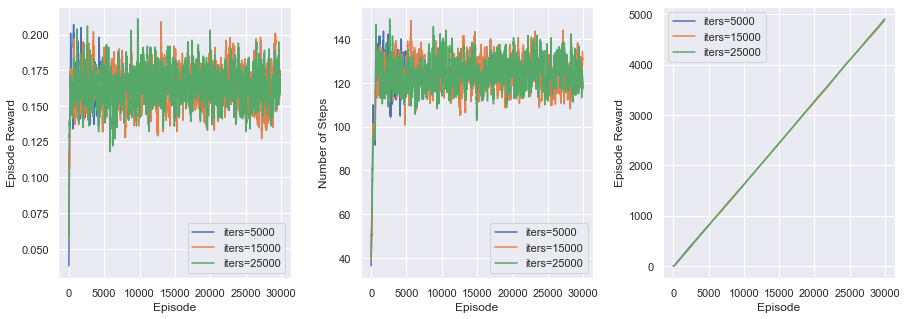

In [56]:
# Moving average function adopted from https://stackoverflow.com/questions/14313510/how-to-calculate-moving-average-using-numpy
def moving_average(x, n):
    return np.convolve(x, np.ones(n), 'valid') / n

ma_score_5000 = moving_average(score_5000, n=100)
ma_score_15000 = moving_average(score_15000, n=100)
ma_score_25000 = moving_average(score_25000, n=100)
ma_steps_5000 = moving_average(steps_5000, n=100)
ma_steps_15000 = moving_average(steps_15000, n=100)
ma_steps_25000 = moving_average(steps_25000, n=100)

fig = plt.figure(figsize=(15,5))
sns.set(color_codes=True)
plt.subplots_adjust(wspace=0.3)
plt.subplot(1,3,1)
plt.plot(ma_score_5000, label = 'iters=5000')
#plt.axvline(x=iteration_converged_100, color = 'blue')
plt.plot(ma_score_15000, label = 'iters=15000')
#plt.axvline(x=iteration_converged_15000, color = 'orange')
plt.plot(ma_score_25000, label = 'iters=25000')
#plt.axvline(x=iteration_converged_25000, color = 'green')
plt.xlabel('Episode')
plt.ylabel('Episode Reward')
plt.grid(True)
plt.legend()
plt.subplot(1,3,3)
plt.plot(cum_score_5000, label = 'iters=5000')
#plt.axvline(x=iteration_converged_100, color = 'blue')
plt.plot(cum_score_15000, label = 'iters=15000')
#plt.axvline(x=iteration_converged_15000, color = 'orange')
plt.plot(cum_score_25000, label = 'iters=25000')
#plt.axvline(x=iteration_converged_25000, color = 'green')
plt.xlabel('Episode')
plt.ylabel('Episode Reward')
plt.grid(True)
plt.legend()
plt.subplot(1,3,2)
plt.plot(ma_steps_5000, label = 'iters=5000')
#plt.axvline(x=iteration_converged_100, color = 'blue')
plt.plot(ma_steps_15000, label = 'iters=15000')
#plt.axvline(x=iteration_converged_15000, color = 'orange')
plt.plot(ma_steps_25000, label = 'iters=25000')
#plt.axvline(x=iteration_converged_25000, color = 'green')
plt.xlabel('Episode')
plt.ylabel('Number of Steps')
plt.grid(True)
plt.legend()

In [57]:
# Policy iteration adopted from https://medium.com/@m.alzantot/deep-reinforcement-learning-demysitifed-episode-2-policy-iteration-value-iteration-and-q-978f9e89ddaa
import numpy as np
import gym
from gym import wrappers


def run_episode(env, policy, gamma = 1.0, render = False):
    """ Evaluates policy by using it to run an episode and finding its
    total reward.
    args:
    env: gym environment.
    policy: the policy to be used.
    gamma: discount factor.
    render: boolean to turn rendering on/off.
    returns:
    total reward: real value of the total reward recieved by agent under policy.
    """
    obs = env.reset()
    total_reward = 0
    step_idx = 0
    while True:
        if render:
            env.render()
        obs, reward, done , _ = env.step(int(policy[obs]))
        total_reward += (gamma ** step_idx * reward)
        step_idx += 1
        if done:
            break
    return total_reward, step_idx


def evaluate_policy(env, policy, gamma = 1.0,  n = 100):
    """ Evaluates a policy by running it n times.
    returns:
    average total reward
    """
    ev_scores = []
    ev_steps = []
    for i in range(n):
        scores, steps = run_episode(env, policy, gamma = gamma, render = False)
        ev_scores.append(scores)
        ev_steps.append(steps)
    #scores, steps = [
    #        run_episode(env, policy, gamma = gamma, render = False)
    #        for _ in range(n)]
    return np.mean(ev_scores), np.mean(ev_steps)

def extract_policy(v, gamma = 1.0):
    """ Extract the policy given a value-function """
    policy = np.zeros(env.nS)
    for s in range(env.nS):
        q_sa = np.zeros(env.nA)
        for a in range(env.nA):
            q_sa[a] = sum([p * (r + gamma * v[s_]) for p, s_, r, _ in  env.P[s][a]])
        policy[s] = np.argmax(q_sa)
    return policy

def compute_policy_v(env, policy, gamma=1.0):
    """ Iteratively evaluate the value-function under policy.
    Alternatively, we could formulate a set of linear equations in iterms of v[s] 
    and solve them to find the value function.
    """
    v = np.zeros(env.nS)
    eps = 1e-10
    while True:
        prev_v = np.copy(v)
        for s in range(env.nS):
            policy_a = policy[s]
            v[s] = sum([p * (r + gamma * prev_v[s_]) for p, s_, r, _ in env.P[s][policy_a]])
        if (np.sum((np.fabs(prev_v - v))) <= eps):
            # value converged
            break
            
    return v

def policy_iteration(env, gamma = 1.0, training_iters = 5000):
    if training_iters > 0 and training_iters <= 5000:
        max_iterations = 5000
    else:
        max_iterations = 30000
    """ Policy-Iteration algorithm """
    score = []
    cum_score = []
    steps = []
    runtime = []
    v = np.zeros(env.nS)  # initialize value-function
    max_iterations = 5000
    total_score = 0   
    
    policy = np.random.choice(env.nA, size=(env.nS))  # initialize a random policy
    for i in range(max_iterations):
        t0 = time.time()
        old_policy_v = compute_policy_v(env, policy, gamma)
        new_policy = extract_policy(old_policy_v, gamma)
        iteration_score, steps_idx = evaluate_policy(env, new_policy, gamma, n=10)
        total_score += iteration_score
        score.append(iteration_score) 
        cum_score.append(total_score)
        steps.append(steps_idx)
        
        if (np.all(policy == new_policy)) or (i == training_iters):
            print ('Policy-Iteration converged at step %d.' %(i+1))
            iteration_converged = i
            t1 = time.time()
            run = t1-t0
            runtime.append(run)
            break
        policy = new_policy
        
    iterations_remaining = max_iterations - i
    
    for rem in range(iterations_remaining):
        t0 = time.time()
        #policy = extract_policy(v, gamma)
        iteration_score, steps_idx = evaluate_policy(env, new_policy, gamma, n=10)
        total_score += iteration_score
        score.append(iteration_score)
        cum_score.append(total_score)
        steps.append(steps_idx)
        t1 = time.time()
        run = t1-t0
        runtime.append(run)
            
    return policy, score, cum_score, iteration_converged, steps, runtime


In [65]:
%%time
env = FrozenLakeEnv(map_name = None, custom_map = 8)
gamma = 1.0
#env.render()
optimal_p_100, score_100, cum_score_100, iteration_converged_100, steps_100, run100spi = policy_iteration(env, gamma, training_iters = 100);
optimal_p_1000, score_1000, cum_score_1000, iteration_converged_1000, steps_1000, run1000spi = policy_iteration(env, gamma, training_iters = 1000);
optimal_p_5000, score_5000, cum_score_5000, iteration_converged_5000, steps_5000, run5000spi = policy_iteration(env, gamma, training_iters = 5000);

Policy-Iteration converged at step 5.
Policy-Iteration converged at step 8.
Policy-Iteration converged at step 4.
Wall time: 31.7 s


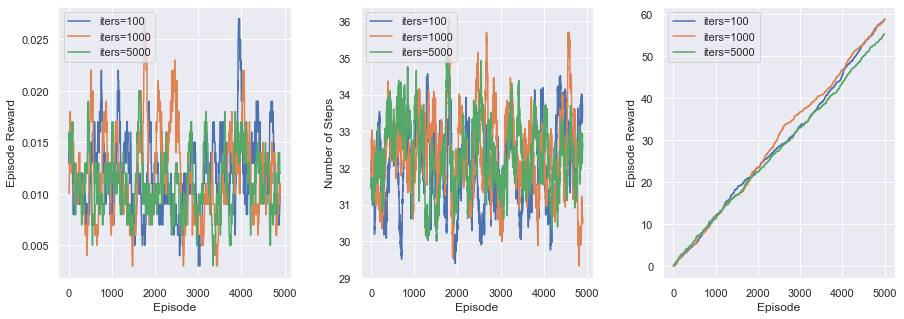

In [66]:
# Moving average function adopted from https://stackoverflow.com/questions/14313510/how-to-calculate-moving-average-using-numpy
def moving_average(x, n):
    return np.convolve(x, np.ones(n), 'valid') / n

ma_score_100 = moving_average(score_100, n=100)
ma_score_1000 = moving_average(score_1000, n=100)
ma_score_5000 = moving_average(score_5000, n=100)
ma_steps_100 = moving_average(steps_100, n=100)
ma_steps_1000 = moving_average(steps_1000, n=100)
ma_steps_5000 = moving_average(steps_5000, n=100)

fig = plt.figure(figsize=(15,5))
sns.set(color_codes=True)
plt.subplots_adjust(wspace=0.3)
plt.subplot(1,3,1)
plt.plot(ma_score_100, label = 'iters=100')
#plt.axvline(x=iteration_converged_100, color = 'blue')
plt.plot(ma_score_1000, label = 'iters=1000')
#plt.axvline(x=iteration_converged_1000, color = 'orange')
plt.plot(ma_score_5000, label = 'iters=5000')
#plt.axvline(x=iteration_converged_5000, color = 'green')
plt.xlabel('Episode')
plt.ylabel('Episode Reward')
plt.grid(True)
plt.legend()
plt.subplot(1,3,3)
plt.plot(cum_score_100, label = 'iters=100')
#plt.axvline(x=iteration_converged_100, color = 'blue')
plt.plot(cum_score_1000, label = 'iters=1000')
#plt.axvline(x=iteration_converged_1000, color = 'orange')
plt.plot(cum_score_5000, label = 'iters=5000')
#plt.axvline(x=iteration_converged_5000, color = 'green')
plt.xlabel('Episode')
plt.ylabel('Episode Reward')
plt.grid(True)
plt.legend()
plt.subplot(1,3,2)
plt.plot(ma_steps_100, label = 'iters=100')
#plt.axvline(x=iteration_converged_100, color = 'blue')
plt.plot(ma_steps_1000, label = 'iters=1000')
#plt.axvline(x=iteration_converged_1000, color = 'orange')
plt.plot(ma_steps_5000, label = 'iters=5000')
#plt.axvline(x=iteration_converged_5000, color = 'green')
plt.xlabel('Episode')
plt.ylabel('Number of Steps')
plt.grid(True)
plt.legend()

In [67]:
%%time
env = FrozenLakeEnv(map_name = None, custom_map = 15)
gamma = 1.0
#env.render()
optimal_v_5000, score_5000, cum_score_5000, iteration_converged_5000, steps_5000, run5000lpi = policy_iteration(env, gamma, training_iters = 5000);
optimal_v_15000, score_15000, cum_score_15000, iteration_converged_15000, steps_15000, run15000lpi = policy_iteration(env, gamma, training_iters = 15000);
optimal_v_25000, score_25000, cum_score_25000, iteration_converged_25000, steps_25000, run25000lpi = policy_iteration(env, gamma, training_iters = 25000);

Policy-Iteration converged at step 9.
Policy-Iteration converged at step 10.
Policy-Iteration converged at step 9.
Wall time: 8min 13s


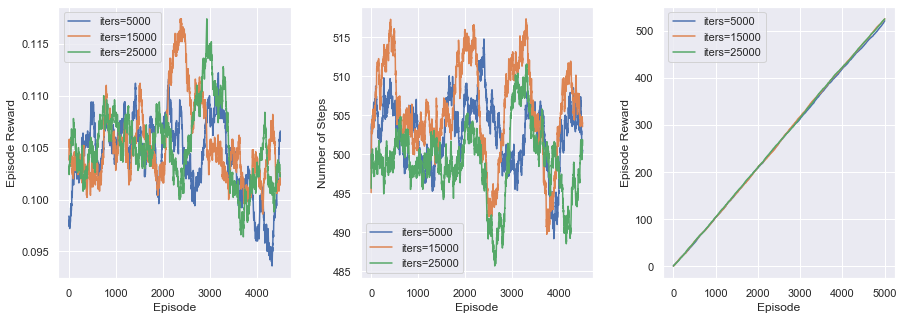

In [68]:
# Moving average function adopted from https://stackoverflow.com/questions/14313510/how-to-calculate-moving-average-using-numpy
def moving_average(x, n):
    return np.convolve(x, np.ones(n), 'valid') / n

ma_score_5000 = moving_average(score_5000, n=500)
ma_score_15000 = moving_average(score_15000, n=500)
ma_score_25000 = moving_average(score_25000, n=500)
ma_steps_5000 = moving_average(steps_5000, n=500)
ma_steps_15000 = moving_average(steps_15000, n=500)
ma_steps_25000 = moving_average(steps_25000, n=500)

fig = plt.figure(figsize=(15,5))
sns.set(color_codes=True)
plt.subplots_adjust(wspace=0.3)
plt.subplot(1,3,1)
plt.plot(ma_score_5000, label = 'iters=5000')
#plt.axvline(x=iteration_converged_100, color = 'blue')
plt.plot(ma_score_15000, label = 'iters=15000')
#plt.axvline(x=iteration_converged_15000, color = 'orange')
plt.plot(ma_score_25000, label = 'iters=25000')
#plt.axvline(x=iteration_converged_25000, color = 'green')
plt.xlabel('Episode')
plt.ylabel('Episode Reward')
plt.grid(True)
plt.legend()
plt.subplot(1,3,3)
plt.plot(cum_score_5000, label = 'iters=5000')
#plt.axvline(x=iteration_converged_100, color = 'blue')
plt.plot(cum_score_15000, label = 'iters=15000')
#plt.axvline(x=iteration_converged_15000, color = 'orange')
plt.plot(cum_score_25000, label = 'iters=25000')
#plt.axvline(x=iteration_converged_25000, color = 'green')
plt.xlabel('Episode')
plt.ylabel('Episode Reward')
plt.grid(True)
plt.legend()
plt.subplot(1,3,2)
plt.plot(ma_steps_5000, label = 'iters=5000')
#plt.axvline(x=iteration_converged_100, color = 'blue')
plt.plot(ma_steps_15000, label = 'iters=15000')
#plt.axvline(x=iteration_converged_15000, color = 'orange')
plt.plot(ma_steps_25000, label = 'iters=25000')
#plt.axvline(x=iteration_converged_25000, color = 'green')
plt.xlabel('Episode')
plt.ylabel('Number of Steps')
plt.grid(True)
plt.legend()

In [71]:
# Q-learning adopted from https://gist.github.com/simoninithomas/baafe42d1a665fb297ca669aa2fa6f92

def Q_learning(env, epsilon = 1.0, decay = False, training_iters = 5000):
    if training_iters < 5000:
        total_episodes = 5000
    else:
        total_episodes = 30000        # Total episodes
    learning_rate = 0.8           # Learning rate
    max_steps = 1500                # Max steps per episode
    gamma = 0.95                  # Discounting rate

    # Exploration parameters
    epsilon = epsilon                 # Exploration rate
    max_epsilon = 1.0             # Exploration probability at start
    min_epsilon = 0.01            # Minimum exploration probability 
    #decay_rate = 0.0005             # Exponential decay rate for exploration prob
    decay_rate = 0.999995
    
    # Metrics
    steps = []
    score = []
    cum_score = []
    runtime = []
    tot_score = 0
    qtable = np.zeros([env.nS, env.nA])

    # 2 For life or until learning is stopped
    for episode in range(total_episodes):
        # Reset the environment
        state = env.reset()
        step = 0
        done = False
        episode_rewards = 0
        t0 = time.time()
        for step in range(max_steps):
            # 3. Choose an action a in the current world state (s)
            ## First we randomize a number
            if episode >= training_iters:
                action = np.argmax(qtable[state,:])
            elif epsilon > random.uniform(0,1):
                action = env.action_space.sample()
            else:
                action = np.argmax(qtable[state,:])
            
            #exp_exp_tradeoff = random.uniform(0, 1)

            ## If this number > greater than epsilon --> exploitation (taking the biggest Q value for this state)
            #if exp_exp_tradeoff > epsilon or episode >= training_iters:
            #    action = np.argmax(qtable[state,:])
            # Else doing a random choice --> exploration    
            #else:
            #    action = env.action_space.sample()

            # Take the action (a) and observe the outcome state(s') and reward (r)
            new_state, reward, done, info = env.step(action)

            # Update Q(s,a):= Q(s,a) + lr [R(s,a) + gamma * max Q(s',a') - Q(s,a)]
            # qtable[new_state,:] : all the actions we can take from new state
            qtable[state, action] = qtable[state, action] + learning_rate * (reward + gamma * np.max(qtable[new_state, :]) - qtable[state, action])

            # Our new state is state
            state = new_state

            #episode_rewards += reward
            
            # If done (if we're dead) : finish episode
            if done == True: 
                #print("Done!")
                break
                
        t1 = time.time()
        run = t1-t0
        runtime.append(run)
        episode_rewards += reward
        
        # Reduce epsilon (because we need less and less exploration)
        if decay == True:
            epsilon = epsilon*decay_rate
        #epsilon = min_epsilon + (max_epsilon - min_epsilon)*np.exp(-decay_rate*episode) 
        tot_score += episode_rewards
        score.append(episode_rewards)
        cum_score.append(tot_score)
        steps.append(step)
        #rewards.append(total_rewards)
        #print(cum_score)
    return score, cum_score, steps, runtime

#print ("Score over time: " +  str(sum(score)/total_episodes))
#print(qtable)


In [73]:
%%time
env = FrozenLakeEnv(map_name = None, custom_map = 8)
#env.render()
score_100, cum_score_100, steps_100, runep25sq = Q_learning(env, epsilon = 0.25, decay = False, training_iters = 4000);
score_1000, cum_score_1000, steps_1000, runep60sq = Q_learning(env, epsilon = 0.60, decay = False, training_iters = 4000);
score_5000, cum_score_5000, steps_5000, runep99sq = Q_learning(env, epsilon = 0.99, decay = False, training_iters = 4000);

Wall time: 860 ms


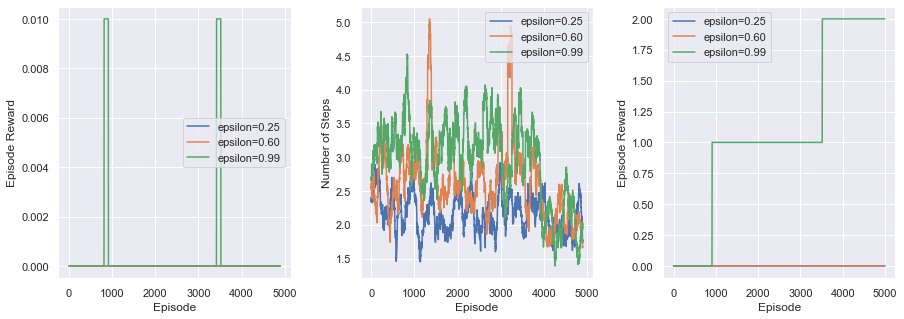

In [74]:
# Moving average function adopted from https://stackoverflow.com/questions/14313510/how-to-calculate-moving-average-using-numpy
def moving_average(x, n):
    return np.convolve(x, np.ones(n), 'valid') / n

ma_score_100 = moving_average(score_100, n=100)
ma_score_1000 = moving_average(score_1000, n=100)
ma_score_5000 = moving_average(score_5000, n=100)
ma_steps_100 = moving_average(steps_100, n=100)
ma_steps_1000 = moving_average(steps_1000, n=100)
ma_steps_5000 = moving_average(steps_5000, n=100)

fig = plt.figure(figsize=(15,5))
sns.set(color_codes=True)
plt.subplots_adjust(wspace=0.3)
plt.subplot(1,3,1)
plt.plot(ma_score_100, label = 'epsilon=0.25')
#plt.axvline(x=iteration_converged_100, color = 'blue')
plt.plot(ma_score_1000, label = 'epsilon=0.60')
#plt.axvline(x=iteration_converged_1000, color = 'orange')
plt.plot(ma_score_5000, label = 'epsilon=0.99')
#plt.axvline(x=iteration_converged_5000, color = 'green')
plt.xlabel('Episode')
plt.ylabel('Episode Reward')
plt.grid(True)
plt.legend()
plt.subplot(1,3,3)
plt.plot(cum_score_100, label = 'epsilon=0.25')
#plt.axvline(x=iteration_converged_100, color = 'blue')
plt.plot(cum_score_1000, label = 'epsilon=0.60')
#plt.axvline(x=iteration_converged_1000, color = 'orange')
plt.plot(cum_score_5000, label = 'epsilon=0.99')
#plt.axvline(x=iteration_converged_5000, color = 'green')
plt.xlabel('Episode')
plt.ylabel('Episode Reward')
plt.grid(True)
plt.legend()
plt.subplot(1,3,2)
plt.plot(ma_steps_100, label = 'epsilon=0.25')
#plt.axvline(x=iteration_converged_100, color = 'blue')
plt.plot(ma_steps_1000, label = 'epsilon=0.60')
#plt.axvline(x=iteration_converged_1000, color = 'orange')
plt.plot(ma_steps_5000, label = 'epsilon=0.99')
#plt.axvline(x=iteration_converged_5000, color = 'green')
plt.xlabel('Episode')
plt.ylabel('Number of Steps')
plt.grid(True)
plt.legend()

In [79]:
%%time
env = FrozenLakeEnv(map_name = None, custom_map = 8)
epsilon = 1.0
#env.render()
score_100, cum_score_100, steps_100, run100sqd = Q_learning(env, epsilon, decay = True, training_iters = 100);
score_1000, cum_score_1000, steps_1000, run1000sqd = Q_learning(env, epsilon, decay = True, training_iters = 1000);
score_5000, cum_score_5000, steps_5000, run5000sqd = Q_learning(env, epsilon, decay = True, training_iters = 3000);

Wall time: 1min 39s


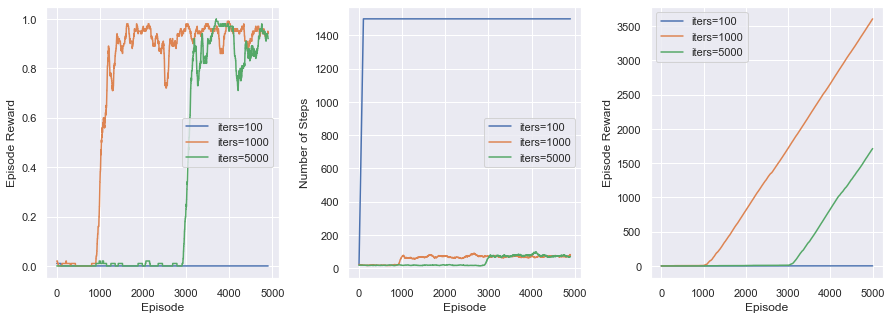

In [80]:
# Moving average function adopted from https://stackoverflow.com/questions/14313510/how-to-calculate-moving-average-using-numpy
def moving_average(x, n):
    return np.convolve(x, np.ones(n), 'valid') / n

ma_score_100 = moving_average(score_100, n=100)
ma_score_1000 = moving_average(score_1000, n=100)
ma_score_5000 = moving_average(score_5000, n=100)
ma_steps_100 = moving_average(steps_100, n=100)
ma_steps_1000 = moving_average(steps_1000, n=100)
ma_steps_5000 = moving_average(steps_5000, n=100)

fig = plt.figure(figsize=(15,5))
sns.set(color_codes=True)
plt.subplots_adjust(wspace=0.3)
plt.subplot(1,3,1)
plt.plot(ma_score_100, label = 'iters=100')
#plt.axvline(x=iteration_converged_100, color = 'blue')
plt.plot(ma_score_1000, label = 'iters=1000')
#plt.axvline(x=iteration_converged_1000, color = 'orange')
plt.plot(ma_score_5000, label = 'iters=5000')
#plt.axvline(x=iteration_converged_5000, color = 'green')
plt.xlabel('Episode')
plt.ylabel('Episode Reward')
plt.grid(True)
plt.legend()
plt.subplot(1,3,3)
plt.plot(cum_score_100, label = 'iters=100')
#plt.axvline(x=iteration_converged_100, color = 'blue')
plt.plot(cum_score_1000, label = 'iters=1000')
#plt.axvline(x=iteration_converged_1000, color = 'orange')
plt.plot(cum_score_5000, label = 'iters=5000')
#plt.axvline(x=iteration_converged_5000, color = 'green')
plt.xlabel('Episode')
plt.ylabel('Episode Reward')
plt.grid(True)
plt.legend()
plt.subplot(1,3,2)
plt.plot(ma_steps_100, label = 'iters=100')
#plt.axvline(x=iteration_converged_100, color = 'blue')
plt.plot(ma_steps_1000, label = 'iters=1000')
#plt.axvline(x=iteration_converged_1000, color = 'orange')
plt.plot(ma_steps_5000, label = 'iters=5000')
#plt.axvline(x=iteration_converged_5000, color = 'green')
plt.xlabel('Episode')
plt.ylabel('Number of Steps')
plt.grid(True)
plt.legend()

In [112]:
%%time
env = FrozenLakeEnv(map_name = None, custom_map = 15)
#env.render()
score_5000, cum_score_5000, steps_5000, runep25lq = Q_learning(env, epsilon = 0.25, decay = False, training_iters = 25000);
score_15000, cum_score_15000, steps_15000, runep60lq = Q_learning(env, epsilon = 0.60, decay = False, training_iters = 25000);
score_25000, cum_score_25000, steps_25000, runep99lq = Q_learning(env, epsilon = 0.99, decay = False, training_iters = 25000);

Wall time: 26.8 s


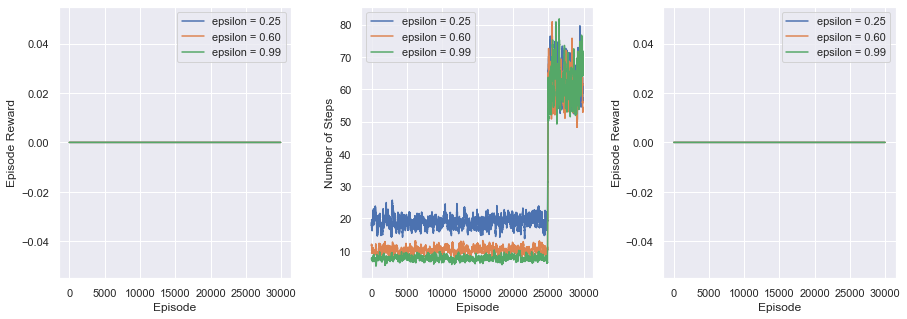

In [113]:
# Moving average function adopted from https://stackoverflow.com/questions/14313510/how-to-calculate-moving-average-using-numpy
def moving_average(x, n):
    return np.convolve(x, np.ones(n), 'valid') / n

ma_score_5000 = moving_average(score_5000, n=100)
ma_score_15000 = moving_average(score_15000, n=100)
ma_score_25000 = moving_average(score_25000, n=100)
ma_steps_5000 = moving_average(steps_5000, n=100)
ma_steps_15000 = moving_average(steps_15000, n=100)
ma_steps_25000 = moving_average(steps_25000, n=100)

fig = plt.figure(figsize=(15,5))
sns.set(color_codes=True)
plt.subplots_adjust(wspace=0.3)
plt.subplot(1,3,1)
plt.plot(ma_score_5000, label = 'epsilon = 0.25')
#plt.axvline(x=iteration_converged_100, color = 'blue')
plt.plot(ma_score_15000, label = 'epsilon = 0.60')
#plt.axvline(x=iteration_converged_15000, color = 'orange')
plt.plot(ma_score_25000, label = 'epsilon = 0.99')
#plt.axvline(x=iteration_converged_25000, color = 'green')
plt.xlabel('Episode')
plt.ylabel('Episode Reward')
plt.grid(True)
plt.legend()
plt.subplot(1,3,3)
plt.plot(cum_score_5000, label = 'epsilon = 0.25')
#plt.axvline(x=iteration_converged_100, color = 'blue')
plt.plot(cum_score_15000, label = 'epsilon = 0.60')
#plt.axvline(x=iteration_converged_15000, color = 'orange')
plt.plot(cum_score_25000, label = 'epsilon = 0.99')
#plt.axvline(x=iteration_converged_25000, color = 'green')
plt.xlabel('Episode')
plt.ylabel('Episode Reward')
plt.grid(True)
plt.legend()
plt.subplot(1,3,2)
plt.plot(ma_steps_5000, label = 'epsilon = 0.25')
#plt.axvline(x=iteration_converged_100, color = 'blue')
plt.plot(ma_steps_15000, label = 'epsilon = 0.60')
#plt.axvline(x=iteration_converged_15000, color = 'orange')
plt.plot(ma_steps_25000, label = 'epsilon = 0.99')
#plt.axvline(x=iteration_converged_25000, color = 'green')
plt.xlabel('Episode')
plt.ylabel('Number of Steps')
plt.grid(True)
plt.legend()

In [88]:
%%time
env = FrozenLakeEnv(map_name = None, custom_map = 15)
epsilon = 1.0
#env.render()
score_5000, cum_score_5000, steps_5000, run5000qd = Q_learning(env, epsilon, decay = True, training_iters = 5000);
score_15000, cum_score_15000, steps_15000, run15000qd = Q_learning(env, epsilon, decay = True, training_iters = 15000);
score_25000, cum_score_25000, steps_25000, run25000qd = Q_learning(env, epsilon, decay = True, training_iters = 25000);

Wall time: 54.2 s


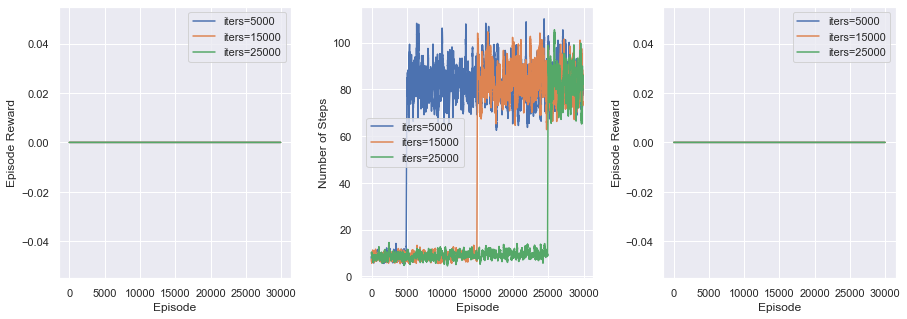

In [89]:
# Moving average function adopted from https://stackoverflow.com/questions/14313510/how-to-calculate-moving-average-using-numpy
def moving_average(x, n):
    return np.convolve(x, np.ones(n), 'valid') / n

ma_score_5000 = moving_average(score_5000, n=100)
ma_score_15000 = moving_average(score_15000, n=100)
ma_score_25000 = moving_average(score_25000, n=100)
ma_steps_5000 = moving_average(steps_5000, n=100)
ma_steps_15000 = moving_average(steps_15000, n=100)
ma_steps_25000 = moving_average(steps_25000, n=100)

fig = plt.figure(figsize=(15,5))
sns.set(color_codes=True)
plt.subplots_adjust(wspace=0.3)
plt.subplot(1,3,1)
plt.plot(ma_score_5000, label = 'iters=5000')
#plt.axvline(x=iteration_converged_100, color = 'blue')
plt.plot(ma_score_15000, label = 'iters=15000')
#plt.axvline(x=iteration_converged_15000, color = 'orange')
plt.plot(ma_score_25000, label = 'iters=25000')
#plt.axvline(x=iteration_converged_25000, color = 'green')
plt.xlabel('Episode')
plt.ylabel('Episode Reward')
plt.grid(True)
plt.legend()
plt.subplot(1,3,3)
plt.plot(cum_score_5000, label = 'iters=5000')
#plt.axvline(x=iteration_converged_100, color = 'blue')
plt.plot(cum_score_15000, label = 'iters=15000')
#plt.axvline(x=iteration_converged_15000, color = 'orange')
plt.plot(cum_score_25000, label = 'iters=25000')
#plt.axvline(x=iteration_converged_25000, color = 'green')
plt.xlabel('Episode')
plt.ylabel('Episode Reward')
plt.grid(True)
plt.legend()
plt.subplot(1,3,2)
plt.plot(ma_steps_5000, label = 'iters=5000')
#plt.axvline(x=iteration_converged_100, color = 'blue')
plt.plot(ma_steps_15000, label = 'iters=15000')
#plt.axvline(x=iteration_converged_15000, color = 'orange')
plt.plot(ma_steps_25000, label = 'iters=25000')
#plt.axvline(x=iteration_converged_25000, color = 'green')
plt.xlabel('Episode')
plt.ylabel('Number of Steps')
plt.grid(True)
plt.legend()

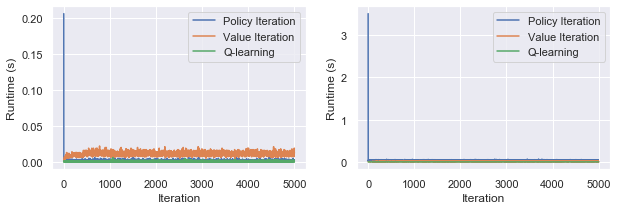

In [107]:
fig = plt.figure(figsize=(10,3))
sns.set(color_codes=True)
plt.subplots_adjust(wspace=0.2)
plt.subplot(1,2,1)
plt.plot(run1000spi, label = 'Policy Iteration')
plt.plot(run1000svi, label = 'Value Iteration')
plt.plot(run1000sqd, label = 'Q-learning')
plt.xlabel("Iteration")
plt.ylabel("Runtime (s)")
plt.legend()
plt.subplot(1,2,2)
run5000lqd = run5000qd[:5000]
plt.plot(run5000lpi, label = 'Policy Iteration')
plt.plot(run5000lvi, label = 'Value Iteration')
plt.plot(run5000lqd, label = 'Q-learning')
plt.xlabel("Iteration")
plt.ylabel("Runtime (s)")
plt.legend()